In [1]:
from __future__ import print_function
import pretty_midi
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# For putting audio in the notebook
import IPython.display
midi_data = pretty_midi.PrettyMIDI('G:/钢琴曲子/01/hhyy1.mid')
# Print an empirical estimate of its global tempo
print(midi_data.instruments)
a = midi_data.instruments[0].get_piano_roll()
b = midi_data.instruments[3].get_piano_roll()
len(midi_data.instruments[3].notes)
c= (midi_data.instruments[3])

for instr_num in range (len(midi_data.instruments)):
    if not midi_data.instruments[instr_num].is_drum:
        instrument= (midi_data.instruments[instr_num])
        print (instrument)
print (instrument)

[Instrument(program=0, is_drum=True, name="untitled"), Instrument(program=23, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=54, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=46, is_drum=False, name="untitled")]
Instrument(program=23, is_drum=False, name="untitled")
Instrument(program=0, is_drum=False, name="untitled")
Instrument(program=54, is_drum=False, name="untitled")
Instrument(program=0, is_drum=False, name="untitled")
Instrument(program=0, is_drum=False, name="untitled")
Instrument(program=0, is_drum=False, name="untitled")
Instrument(program=0, is_drum=False, name="untitled")
Instrument(program=46, is_drum=False, name="untitled")
Instrument(program=46, is_drum=False, name="untitled")


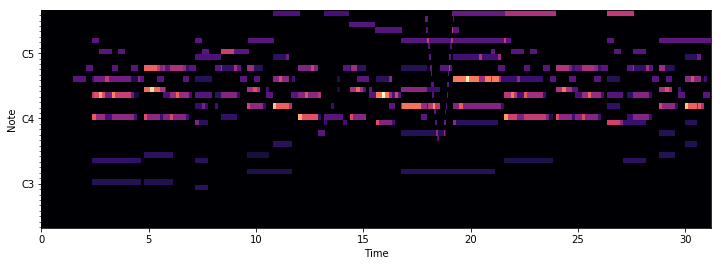

In [2]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],hop_length=1,
                             sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(12, 4))
plot_piano_roll(midi_data, 40,80)

删除通道10的音轨 删除鼓 也可统一音色 只需更改program即可

[Instrument(program=23, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=54, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=0, is_drum=False, name="untitled"), Instrument(program=46, is_drum=False, name="untitled")]


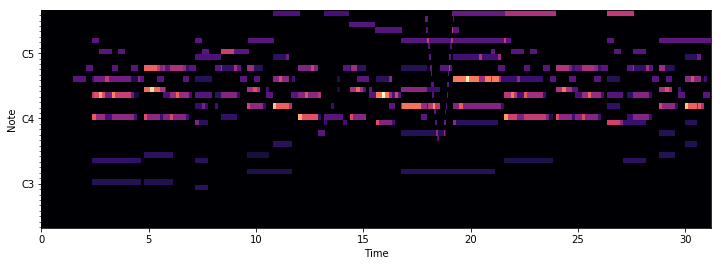

In [3]:
def deleteDrum(midi_data):
    new_midi = pretty_midi.PrettyMIDI()
    notes_velocity = []
    notes_pitch = []
    notes_start = []
    notes_end = []
    for instr_num in range (len(midi_data.instruments)):
        if not midi_data.instruments[instr_num].is_drum:
            instrument = (midi_data.instruments[instr_num])            
            program = instrument.program
            is_drum = instrument.is_drum
            name = instrument.name
            inst = pretty_midi.Instrument(program=program, is_drum=is_drum, name=name)
            new_midi.instruments.append(inst)
            for j in range (len(instrument.notes)):
                note = instrument.notes[j]
                inst.notes.append(pretty_midi.Note(note.velocity, note.pitch, note.start, note.end))
    return new_midi
#注 ：可将该新生成的midi写出来 midi.write即可
new_midi = deleteDrum(midi_data)
#打印新生成的midi         
print(new_midi.instruments)

plt.figure(figsize=(12, 4))
plot_piano_roll(new_midi, 40,80)

将pretty_midi对象转变成数组格式 方便数据处理

In [4]:
def get_train_data(new_midi):
    train_data = []
    for i in range (len(new_midi.instruments)):
        notes =[]
        for j in range (len(new_midi.instruments[i].notes)):
            note = new_midi.instruments[i].notes[j]
            #更改了note事件的参数位置
            notes.append(note.start)
            notes.append(note.end)
            notes.append(note.velocity)
            notes.append(note.pitch)
        a = np.array(notes)
        train_data.append(a)     
    return train_data
train_data=get_train_data(new_midi)
train_data[0]

array([  1.48875,   1.8    , 100.     ,  67.     ,   1.81125,   2.1225 ,
       100.     ,  67.     ,   2.1    ,   2.41125, 100.     ,  69.     ,
         2.4    ,   2.71125, 100.     ,  74.     ,   2.71125,   3.0225 ,
       100.     ,  72.     ,   3.0225 ,   3.33375, 100.     ,  72.     ,
         3.3    ,   3.61125, 100.     ,  69.     ,   3.61125,   3.9225 ,
       100.     ,  72.     ,   4.2    ,   4.51125, 100.     ,  69.     ,
         4.51125,   4.8225 , 100.     ,  67.     ,   4.8    ,   5.11125,
       100.     ,  69.     ,   5.11125,   5.4225 , 100.     ,  69.     ,
         5.41125,   5.7225 , 100.     ,  67.     ,   5.68875,   6.     ,
       100.     ,  69.     ,   6.01125,   6.6    , 100.     ,  69.     ,
         6.6    ,   6.91125, 100.     ,  67.     ,   6.9    ,   7.21125,
       100.     ,  69.     ,   7.2    ,   7.51125, 100.     ,  74.     ,
         7.5225 ,   7.83375, 100.     ,  72.     ,   7.8225 ,   7.83375,
       100.     ,  72.     ,   8.11125,   8.4225 , 

pitch%12 取模 化成十二平均律

def getMod(x):
    for i in range(len(x)):
        for j in range(len(x[i])):
            if (j%4==3):
                x[i][j]= x[i][j]%12
    return x
#train_data_12=getMod(train_data)
#train_data_12[2]
    

skyline算法 以保证每个音轨不存在复调 产生复调的满足以下条件：1.S1<=S2 2.E1>S2

In [5]:
#这是一段丑陋的代码 暂时不优化
def skyline(track):
    siz = len(track)-4
    i=0
    while(i!=siz):
        if ((track[i]<=track[i+4])&(track[i+1] > track[i+4])):
            if ((track[i+3]<track[i+7])):
                track[i+1] = track[i+4]
            else:
                track[i+4] = track[i+1]
        i = i+4
    return track
#track=skyline(train_data_12[2])
#track

    

给所有音轨使用skyline去除复调关系

In [6]:
def allSkyline(s):
    a = []
    for i in range(len(s)):
        a.append(skyline(s[i]))
    return a

simple_data = allSkyline(train_data)
simple_data
        

[array([  1.48875,   1.8    , 100.     ,  67.     ,   1.81125,   2.1    ,
        100.     ,  67.     ,   2.1    ,   2.4    , 100.     ,  69.     ,
          2.4    ,   2.71125, 100.     ,  74.     ,   2.71125,   3.0225 ,
        100.     ,  72.     ,   3.0225 ,   3.33375, 100.     ,  72.     ,
          3.33375,   3.61125, 100.     ,  69.     ,   3.61125,   3.9225 ,
        100.     ,  72.     ,   4.2    ,   4.51125, 100.     ,  69.     ,
          4.51125,   4.8    , 100.     ,  67.     ,   4.8    ,   5.11125,
        100.     ,  69.     ,   5.11125,   5.4225 , 100.     ,  69.     ,
          5.4225 ,   5.68875, 100.     ,  67.     ,   5.68875,   6.     ,
        100.     ,  69.     ,   6.01125,   6.6    , 100.     ,  69.     ,
          6.6    ,   6.9    , 100.     ,  67.     ,   6.9    ,   7.2    ,
        100.     ,  69.     ,   7.2    ,   7.51125, 100.     ,  74.     ,
          7.5225 ,   7.83375, 100.     ,  72.     ,   7.83375,   7.83375,
        100.     ,  72.     ,   8.1112

In [7]:
#初始化音高向量
h=np.zeros((len(simple_data),128),dtype = int)
h.shape

(8, 128)

取出音高求取音高分布

In [8]:
from collections import Counter
#先变为整型
def getPitchInt(a):
    s = []
    for j in range(len(a)):
        if (j%4==3):
            s.append(a[j]+1)
    n = np.array(s,dtype = int)

    return n
pitch_int = getPitchInt(simple_data[0])
print(Counter(pitch_int))


Counter({70: 25, 68: 19, 73: 12, 65: 7, 63: 7, 75: 4, 61: 3, 58: 1, 77: 1})


In [9]:
#统计音高出现次数
def getPitch(simple_data,h):
    s = []
    for i in range(1,129):
        for j in range (len(simple_data)):
             if ((j%4==3)&((simple_data[j]+1)==i)):
                h[i-1]=h[i-1]+1
    return h
h[0] = getPitch(simple_data[0],h[0])
print(simple_data[0])
h[0]


[  1.48875   1.8     100.       67.        1.81125   2.1     100.
  67.        2.1       2.4     100.       69.        2.4       2.71125
 100.       74.        2.71125   3.0225  100.       72.        3.0225
   3.33375 100.       72.        3.33375   3.61125 100.       69.
   3.61125   3.9225  100.       72.        4.2       4.51125 100.
  69.        4.51125   4.8     100.       67.        4.8       5.11125
 100.       69.        5.11125   5.4225  100.       69.        5.4225
   5.68875 100.       67.        5.68875   6.      100.       69.
   6.01125   6.6     100.       69.        6.6       6.9     100.
  67.        6.9       7.2     100.       69.        7.2       7.51125
 100.       74.        7.5225    7.83375 100.       72.        7.83375
   7.83375 100.       72.        8.11125   8.4     100.       69.
   8.4       9.      100.       72.        9.        9.31125 100.
  69.        9.31125   9.6     100.       67.        9.6       9.91125
 100.       69.        9.9225   10.23375 10

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  3,  0,  7,  0,  7,  0,  0, 19,
        0, 25,  0,  0, 12,  0,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [10]:
#生成音高向量 值为每个音符在不同音轨中出现的次数

def pitchVec(a,h):
    for i in range(len(a)):
        w = getPitchInt(a[i])
        h[i] = getPitch(a[i],h[i])
    return h

h= pitchVec(simple_data,h)
k = []
for j in range(len(h)):
    k.append(j)
labels= np.array(k)
labels  
h

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

h_i 第i个音轨的音高分布向量

h_average 平均音高分布向量 =（h_1_averang,...,h_12_averang）

h_i_average 音符为i 在每个音轨中出现的平均次数 T为音轨数 h_i_average = h_k(1——T)_i（累加）/T 

h_wi_average 音符为i 在每个音轨中出现的次数的加权平均值   h_wi_average = h_k(1——T)_i*fk

h_w_average 加权平均分布   

fk 某个音轨音符数/音符总数

In [11]:
h_average= np.average(h,axis=0)
h_average

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
       0.   , 0.75 , 0.75 , 0.   , 1.625, 0.   , 1.25 , 0.   , 0.   ,
       0.75 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.25 , 0.   , 0.25 , 0.   , 0.5  , 0.375,
       0.   , 0.25 , 0.125, 0.75 , 0.   , 1.875, 4.25 , 0.25 , 4.75 ,
       0.   , 6.125, 3.   , 0.25 , 7.5  , 0.25 , 9.125, 0.   , 1.25 ,
       3.25 , 0.25 , 1.625, 0.   , 0.625, 0.125, 0.25 , 0.75 , 0.25 ,
       0.75 , 0.   , 0.25 , 0.   , 0.25 , 0.25 , 0.   , 0.25 , 0.   ,
       0.25 , 0.   , 0.25 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ]

In [12]:
#求fk pitch_num of 音轨i /all pitchs
def get_fk(h):
    ff=[]
    m=0
    pitchsum = np.sum(h)
    print(pitchsum)
    for i in range(len(simple_data)):
        m=(np.sum(h[i]))/pitchsum
        ff.append(m)
    fk= np.array(ff)
    return fk
fk = get_fk(h)
fk

454


array([0.34801762, 0.14757709, 0.09030837, 0.10792952, 0.12114537,
       0.04625551, 0.04405286, 0.09471366])

In [13]:
h_w_average= np.average(h, axis = 0 ,weights = fk)
h_w_average

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.86343612,  0.        ,  0.64757709,  0.64757709,
        0.        ,  1.4030837 ,  0.        ,  1.07929515,  0.        ,
        0.        ,  0.64757709,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.04405286,  0.08810573,  0.        ,
        0.08810573,  0.        ,  0.17621145,  0.13215859,  0.        ,
        0.08810573,  0.09471366,  0.97356828,  0.        ,  1.60352423,
        5.2753304 ,  0.18942731,  7.75330396,  0.        ,  8.93171806,
        2.93832599,  0.18942731, 15.98678414,  0.18942731, 20.24

In [14]:
# 计算h_average和h_w_average向量之间的欧氏距离，欧氏距离计算如下： 
dist1 = np.sqrt(np.sum(np.square(h_w_average- h_average)))
print(dist1)
dist2 = np.linalg.norm(h_w_average- h_average)
dist2

15.646089621432155


15.646089621432157

In [15]:
#层次聚类终止算法的阈值t
t = dist1/2
t

7.823044810716078

In [32]:
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster  
df = pd.DataFrame(h, index = labels)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [45.0, 45.0, 62.5, 62.5],
  [22.5, 22.5, 53.75, 53.75],
  [5.0, 5.0, 38.125, 38.125]],
 'dcoord': [[0.0, 7.745966692414834, 7.745966692414834, 0.0],
  [0.0, 14.047538337136984, 14.047538337136984, 7.745966692414834],
  [0.0, 10.488088481701515, 10.488088481701515, 0.0],
  [0.0, 11.045361017187263, 11.045361017187263, 10.488088481701515],
  [0.0, 26.580067720004024, 26.580067720004024, 11.045361017187263],
  [14.047538337136984,
   37.25043943492798,
   37.25043943492798,
   26.580067720004024],
  [0.0, 86.18626009156812, 86.18626009156812, 37.25043943492798]],
 'ivl': [0, 2, 1, 4, 3, 6, 5, 7],
 'leaves': [0, 2, 1, 4, 3, 6, 5, 7],
 'color_list': ['g', 'g', 'g', 'g', 'g', 'g', 'b']}

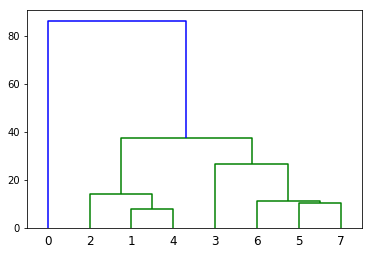

In [17]:
Z = hierarchy.linkage(df, method ='ward',metric='euclidean')
hierarchy.dendrogram(Z,labels = df.index)

可裁剪

In [18]:
label = cluster.hierarchy.cut_tree(Z,height=t)
label = label.reshape(label.size,)
label

array([0, 1, 2, 3, 1, 4, 5, 6])

In [19]:
Z

array([[ 1.        ,  4.        ,  7.74596669,  2.        ],
       [ 5.        ,  7.        , 10.48808848,  2.        ],
       [ 6.        ,  9.        , 11.04536102,  3.        ],
       [ 2.        ,  8.        , 14.04753834,  3.        ],
       [ 3.        , 10.        , 26.58006772,  4.        ],
       [11.        , 12.        , 37.25043943,  7.        ],
       [ 0.        , 13.        , 86.18626009,  8.        ]])

   0    1    2    3    4    5    6    7    8    9   ...   118  119  120  121  \
0    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
5    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
6    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
7    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   122  123  124  125  126  127  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  
5    0    0    0    0    0    0  
6    0    0    0    0    0    0  
7    0 

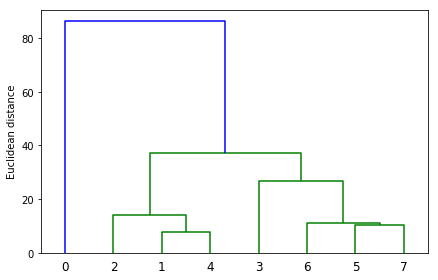

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


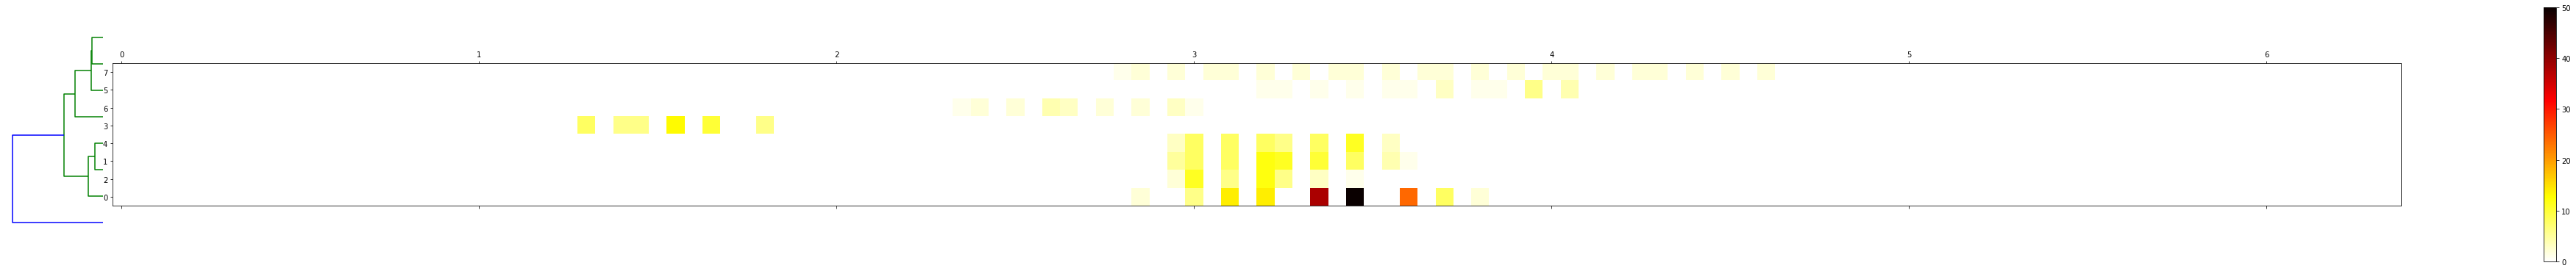

In [31]:
#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
#np.random.seed(123)
#X=np.random.random_sample([5,3])*10
#层次聚类树
#df = pd.DataFrame(X,columns=variables,index=labels)

df = pd.DataFrame(h, index = labels)
print (df)
#计算距离关联矩阵，两两样本间的欧式距离
#row_dist = pd.DataFrame(squareform(pdist(df,metric='euclidean')),columns=labels,index=labels)
#print (row_dist)
#print (help(linkage))
row_clusters = linkage(pdist(df,metric='euclidean'),method='ward')#使用抽秘籍距离矩阵
#row_clusters = linkage(df.values,method='complete',metric='euclidean')
print (pd.DataFrame(row_clusters,columns=['row label1','row label2','distance','no. of items in clust.'],index=['cluster %d'%(i+1) for i in range(row_clusters.shape[0])]))
#层次聚类树
row_dendr = dendrogram(row_clusters,labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()
#层次聚类热度图
fig =plt.figure(figsize=(9,8))
axd =fig.add_axes([0.08,0.16,0.2,0.5])
row_dendr = dendrogram(row_clusters,orientation='left')
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
axm = fig.add_axes([0.3,0.1,6.0,0.6])
cax = axm.matshow(df_rowclust,interpolation='nearest',cmap='hot_r')
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels(['']+list(df_rowclust.columns))
axm.set_yticklabels(['']+list(df_rowclust.index))
plt.show()
 
#凝聚层次聚类，应用对层次聚类树剪枝
ac=AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='complete')
#acc=ac.fit(h)
#label = ac.fit_predict(h)
#print ('cluster labels:%s'%label)

p(i)  音符i在该轨出现的频率
- 求和（1-12）p(i)log12p(i)

In [21]:
#xi=pi(某音块平均音高) +128*calc_ent(ci)  ci 某音轨
import math
def calc_ent(x):
    track_sum=np.sum(x)
    ent = 0.0
    for i in range(len(x)):
        p = x[i]/track_sum
        if (p!=0) :
            logp=math.log(p,128)
            ent -= p*logp
    return ent
c1= calc_ent(h[1])
c1


0.4275602484513778

In [30]:
def calc_xi(h):
    xi = []
    for i in range(len(h)):
         #计算平均音高
        track_average = np.average(h[i])
        xi.append(track_average+128*calc_ent(h[i]))
    xi_ary = np.array(xi)
    return xi_ary
xi = calc_xi(h)
        
dfent = pd.DataFrame(xi, index = label)
dfent

,0
0,48.942555
1,55.251149
2,45.281716
3,46.383124
1,53.259273
4,55.869317
5,55.862569
6,81.698599


选出每簇综合显著度（xi）最大的音轨为代表

In [52]:
al = dfent.loc[1]
aa =al[0].tolist()
maxx = np.max(aa)
maxx

55.25114930177636

In [60]:
def get_xi_max(df,label):
    xi = []
    x_max = 0
    maxx = 0
    lenth = np.max(label)
    for i in range(lenth+1):
        print (i)
        #先将每个簇的数据转为数组 方便比较
        a_label = df.loc[i]
        a_list = a_label[0].tolist()
        x_max = np.max(a_list)
        xi.append(x_max)
    xi_ary = np.array(xi)
    return xi_ary
mmax = get_xi_max(dfent,label)
mmax
    


0
1
2
3
4
5
6


array([48.94255472, 55.2511493 , 45.28171598, 46.38312413, 55.86931714,
       55.86256945, 81.69859933])